# Motion artefact correction and physiological noise removal

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)

## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
    * [Signal quality metrics and channel rejection](#section_1_3)
        * [Visual inspection](#sub_section_1_3_1)
        * [Scalp-coupling index](#sub_section_1_3_2)
        * [Peak spectral power](#sub_section_1_3_3)
    * [Motion artefact correction](#section_1_4)
    * [Short channel regression](#section_1_5)
        * [Method of Saager and Berger](#sub_section_1_5_1)
    * [Global component derived from the mean or median](#section_1_6)
        * [Method of Saager and Berger](#sub_section_1_6_1)
    * [Signal processing methods](#section_1_7)
        * [Lowpass filtering](#sub_section_1_7_1)
* [Post-processing](#chapter_2)
    * [Data preparation](#section_2_1)
        * [Selection channels used in analysis](#sub_section_2_1_1)
        * [Crop and average fNIRS data according to task block](#sub_section_2_1_2)
    * [Data preparation](#section_2_2)
        * [Research question 1](#sub_section_2_2_1)
        * [Research question 2](#sub_section_2_2_2)

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [1]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
import pathlib
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info, source_detector_distances
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import statsmodels_to_results
from mne.preprocessing import ICA, corrmap
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr, shapiro
from scipy.signal import firwin, freqz, filtfilt
from scipy.interpolate import CubicSpline
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
import dataframe_image as dfi
from statsmodels.stats.diagnostic import het_white

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\1527851336.py:25: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Write own fucntions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def add_info2(raw_intensity, first_name, last_name, age, sex, EHI):
    """
    Input: raw object, first name, last name, age, sex, EHI
    Function: Returns raw object with added subject info
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    return raw
    
def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')

    return IMU_data, acc_data, gyro_data

def compare_original_filtered(raw_filtered, raw_unfiltered, export = False, filename = None):
    data_new = raw_filtered.get_data()
    data = raw_unfiltered.get_data()
    picks = np.sort(_validate_nirs_info(raw_filtered.info))
    datatype = raw_filtered.ch_names[0][-3:]
    for pick in picks:
        if plot:
            if datatype == 'hbo':
                type = ' hbo' if pick%2 == 0 else ' hbr'
                ylabel = 'HbO/HbR (M)'
            else:
                type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
                ylabel = 'OD (V)'
            %matplotlib inline
            time = np.arange(data.shape[1])/raw_filtered.info['sfreq']
            fig = plt.figure(figsize = (12,5))
            plt.plot(time, data[pick], label = 'original')
            plt.plot(time, data_new[pick], label = 'filtered')
            plt.xlabel('time (s)')
            plt.ylabel(ylabel)
            plt.title('Channel: ' + str(pick//2+1) + type)
            plt.legend()
            if export:
                if filename == None:
                    raise ValueError('Filename must be given to export figures')
                fig.savefig(filename + '_channel_' + str(pick//2+1) + type + '.png')
            plt.show()

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = False
# Export figures?
export = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [4]:
raws = []
data_dir = pathlib.Path("C:/Users/fabia/fNIRS data analysis/N-back analysis/N_back data_BIDS")
bids_root = data_dir.with_name(data_dir.name)
for sub in range(1, 5):  # Loop from first to fourth subject
    # Create path to file based on experiment info
    bids_path = BIDSPath(subject="%02d" % sub, task="Nback", datatype="nirs",
                         root=bids_root, suffix="nirs",
                         extension=".snirf")
    raws.append(read_raw_bids(bids_path=bids_path, verbose=False))
raws

[<RawSNIRF | sub-01_task-Nback_nirs.snirf, 32 x 20463 (2046.2 s), ~36 kB, data not loaded>,
 <RawSNIRF | sub-02_task-Nback_nirs.snirf, 32 x 40258 (4549.0 s), ~36 kB, data not loaded>,
 <RawSNIRF | sub-03_task-Nback_nirs.snirf, 32 x 20339 (2277.9 s), ~36 kB, data not loaded>,
 <RawSNIRF | sub-04_task-Nback_nirs.snirf, 32 x 21552 (2650.8 s), ~36 kB, data not loaded>]

In [5]:
raw_intensities = []
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
for sub in range(4):
    raw_intensities.append(reorder(raws[sub]))

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [6]:
raw_intensities[0] = add_info2(raw_intensities[0], 'Subject', '1', 23, 'male', 'right')
raw_intensities[1] = add_info2(raw_intensities[1], 'Subject', '2', 22, 'female', 'right')
raw_intensities[2] = add_info2(raw_intensities[2], 'Subject', '3', 25, 'male', 'right')
raw_intensities[3] = add_info2(raw_intensities[3], 'Subject', '4', 25, 'female', 'right')

In [7]:
# Look at characteristics
sfreqs = []
lowpass = []
for sub in range(4):
    sfreqs.append(raw_intensities[sub].info['sfreq'])
    lowpass.append(raw_intensities[sub].info['lowpass'])
print('Sample frequencies (Hz): ' + str(sfreqs))
print('Max bandwidth (Hz): ' + str(lowpass))

Sample frequencies (Hz): [10.0, 8.849557522123893, 8.928571428571429, 8.130081300813009]
Max bandwidth (Hz): [5.0, 4.424778761061947, 4.464285714285714, 4.065040650406504]


Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']
Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']
Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']
Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']


C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\4025079886.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


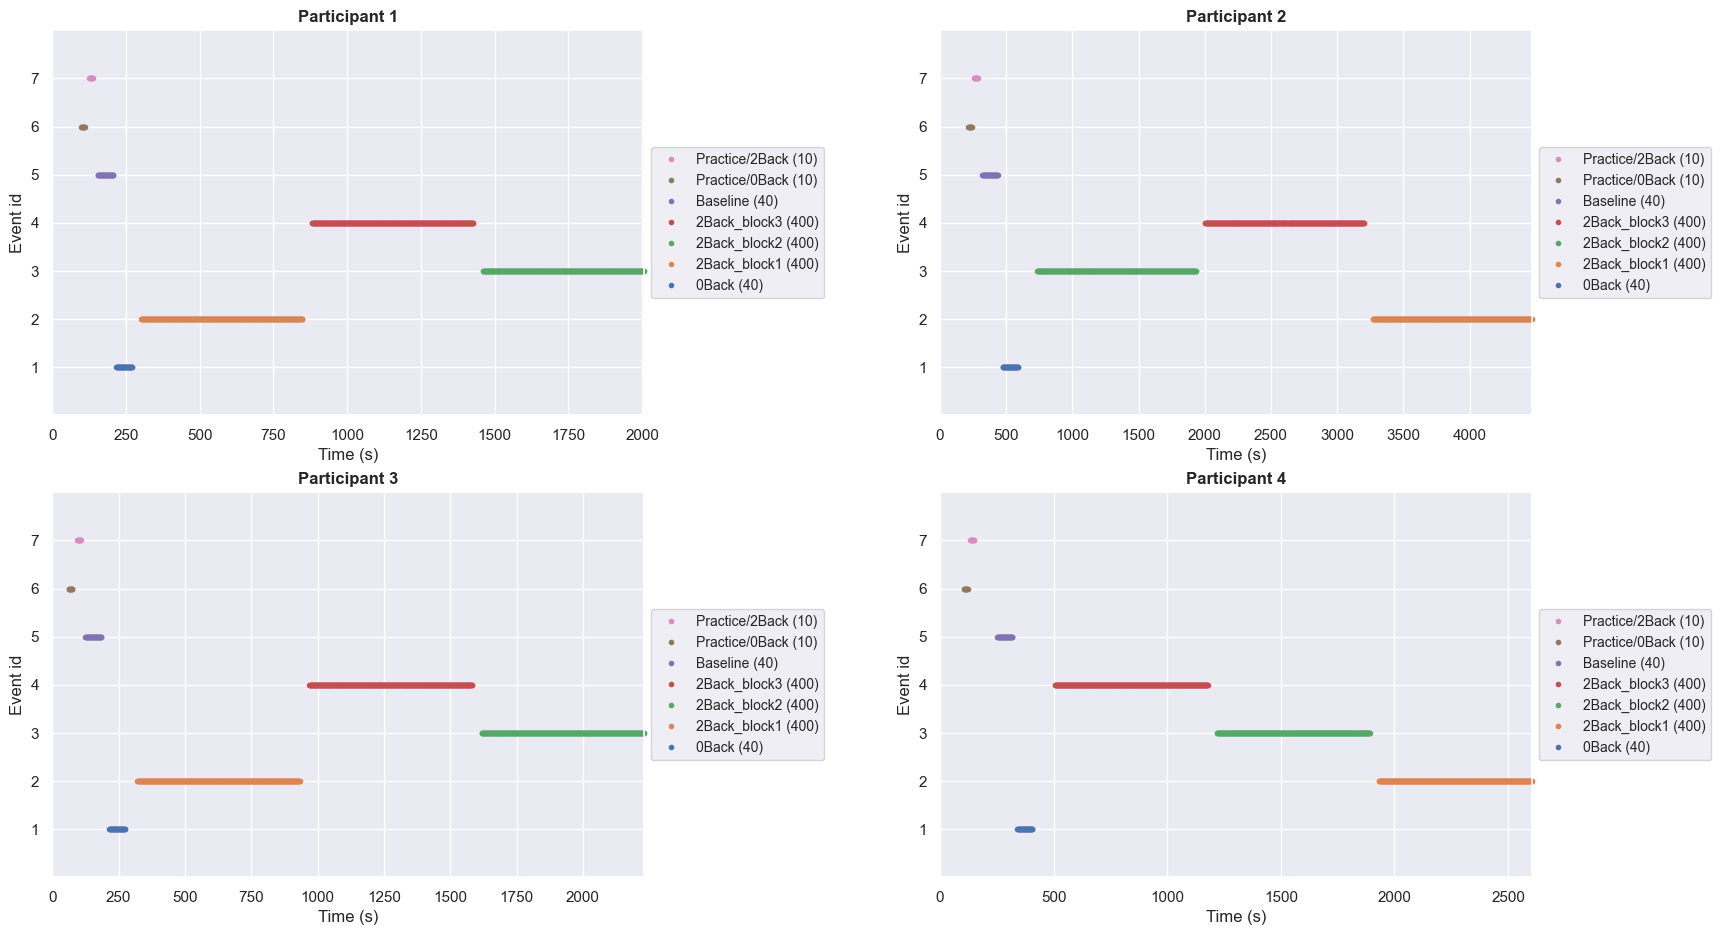

In [8]:
# Look at segments
events = []
event_dicts = []
for sub in range(4):
    event, event_dict = mne.events_from_annotations(raw_intensities[sub])
    events.append(event)
    event_dicts.append(event_dict)
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 11))

mne.viz.plot_events(events[0], event_id=event_dicts[0], sfreq=raw_intensities[0].info['sfreq'], axes=axes[0,0], show = False)
mne.viz.plot_events(events[1], event_id=event_dicts[1], sfreq=raw_intensities[1].info['sfreq'], axes=axes[0,1], show = False)
mne.viz.plot_events(events[2], event_id=event_dicts[2], sfreq=raw_intensities[2].info['sfreq'], axes=axes[1,0], show = False)
mne.viz.plot_events(events[3], event_id=event_dicts[3], sfreq=raw_intensities[3].info['sfreq'], axes=axes[1,1], show = False)
axes[0,0].set_title('Participant 1', fontweight="bold")
axes[0,1].set_title('Participant 2', fontweight="bold")
axes[1,0].set_title('Participant 3', fontweight="bold")
axes[1,1].set_title('Participant 4', fontweight="bold")

fig.show()

---
> *Remark:*
- 16 channels * 2 wavelengths = 32 channels
- Different sample frequencies are used for each participant = [10.0, 8.849557522123893, 8.928571428571429, 8.130081300813009] Hz
- LPF = [5.0, 4.424778761061947, 4.464285714285714, 4.065040650406504] Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
- 10 practice 0-back and 2-back letters were presented
- 40 letters were presented for the 0-back and the baseline recording
- 400 letters were presented for each of the three 2-back blocks
---

##### Validate that the location of sources-detector pairs and channels are in the expected locations

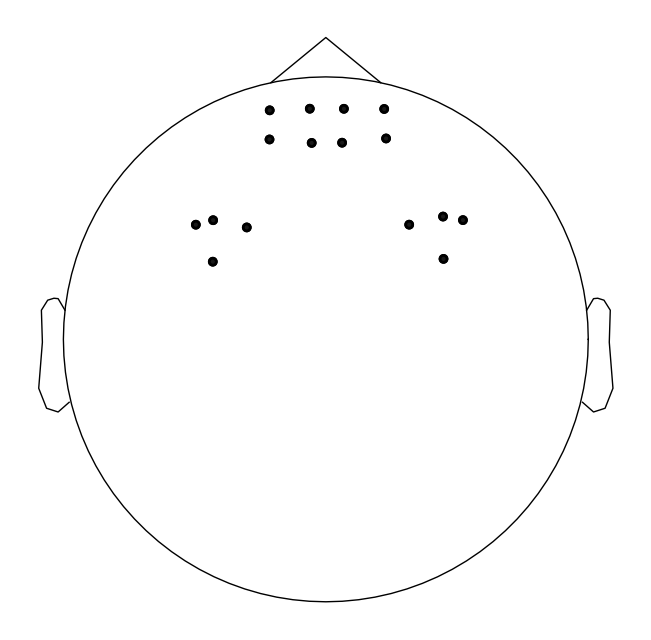

In [9]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensities[0].plot_sensors();

In [10]:
sns.set_theme()

---
> *Remark:*
- 14 long channels and 2 short channels
- 12 sources, 4 detectors and 2 short channel sources
- montage located above prefrontal cortex
---

### Signal quality metrics and channel rejection <a class="anchor" id="section_1_3"></a>

#### Visual inspection <a class="anchor" id="sub_section_1_3_1"></a>

##### Visual inspection of the raw light intensity data

###### Subject 1

In [11]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [12]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [13]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [14]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[3].plot(duration=300, show_scrollbars = True, clipping = None);

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [15]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_ods = []
for sub in range(4):
    raw_ods.append(optical_density(raw_intensities[sub]))

Reading 0 ... 20462  =      0.000 ...  2046.200 secs...
Reading 0 ... 40257  =      0.000 ...  4549.041 secs...
Reading 0 ... 20338  =      0.000 ...  2277.856 secs...
Reading 0 ... 21551  =      0.000 ...  2650.773 secs...


Remark: Negative values in raw intensity due to artefacts

###### Subject 1

In [16]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [17]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [18]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [19]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[3].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- For more information about the visual inspection procedure can be found in the **Signal quality metrics and channel rejection - N-back** Notebook.
---

##### Separate long and short channels

The short channels were not assessed using signal quality metrics because they inherently contain physiological noise. These channels cannot be removed from the dataset as they are essential for performing short channel regression.


In [20]:
raw_ods_full = []
raw_ods_short = []
raw_ods_new = []
min_dist = 0.01 
max_dist = 0.045
for sub in range(4):
    raw_ods_full.append(raw_ods[sub].copy())
    raw_ods_short.append(get_short_channels(raw_ods[sub], max_dist=min_dist))
    raw_ods_new.append(get_long_channels(raw_ods[sub], min_dist=min_dist, max_dist=max_dist))

In [21]:
raw_ods = raw_ods_new

In [22]:
# Short channels are: (channel number 11 and 12)
raw_ods_full[0].ch_names[20:24]

['S13_D3 760', 'S13_D3 850', 'S14_D4 760', 'S14_D4 850']

#### Scalp-coupling index <a class="anchor" id="sub_section_1_3_2"></a>

The SCI is a quality measurement of the connection between the optodes and the scalp of the participant using the strong cardiac oscillation in raw fNIRS signals. With a sufficiently high sampling rate (e.g.: 10 Hz), the heartbeat emerges as a dependable marker for evaluating optode-scalp coupling. It was first introduced by Pollonini et al. (2013) and it assesses the synchronous cardiac pulsation in the two photodetected signals (760 and 850 nm) in the cardiac band (0.5 - 2.5 Hz). After the bandpass-filtering the resulting signals are normalized to balance any difference between their amplitude. Finally, the zero-lag cross-correlation between photodetected signals of the same channel is used as a quantitative measure of the SNR of that specific channel. A threshold of SCI $>$ 0.75 is recommended by the authors.

Given that the frequency band of 0.5 - 2.5 Hz is quite broad and the participants are relatively at rest while seated, a FIR filter with a narrower band of 0.7 - 1.5 Hz is applied (40 bpm - 85 bpm). The transition band width at both the low and high cut-off frequencies is set to 0.3 Hz.

##### SCI evaluated over complete signal

In [23]:
# Calculate SCI with build-in function of mne_nirs
scis = []
for sub in range(4):
    scis.append(scalp_coupling_index(raw_ods[sub], l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False))
    # SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

In [24]:
# Copy raw object to apply SCI 
raw_od_SCIs = []
for sub in range(4):
    raw_od_SCIs.append(raw_ods[sub].copy())
# Mark channels with SCI < 0.75 as BAD
for sub in range(4):
    raw_od_SCIs[sub].info['bads'] = list(compress(raw_ods[sub].ch_names, scis[sub] < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
    print('The ' + str(len(raw_od_SCIs[sub].info['bads'])) + ' bad channels for subject ' + str(sub+1) + ' are: ' + str(raw_od_SCIs[sub].info['bads']))

The 10 bad channels for subject 1 are: ['S4_D3 760', 'S4_D3 850', 'S6_D3 760', 'S6_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D3 760', 'S8_D3 850', 'S9_D4 760', 'S9_D4 850']
The 12 bad channels for subject 2 are: ['S4_D3 760', 'S4_D3 850', 'S5_D4 760', 'S5_D4 850', 'S6_D3 760', 'S6_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D3 760', 'S8_D3 850', 'S9_D4 760', 'S9_D4 850']
The 4 bad channels for subject 3 are: ['S9_D4 760', 'S9_D4 850', 'S12_D2 760', 'S12_D2 850']
The 18 bad channels for subject 4 are: ['S2_D2 760', 'S2_D2 850', 'S5_D4 760', 'S5_D4 850', 'S6_D3 760', 'S6_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D3 760', 'S8_D3 850', 'S9_D4 760', 'S9_D4 850', 'S11_D2 760', 'S11_D2 850', 'S12_D1 760', 'S12_D1 850', 'S12_D2 760', 'S12_D2 850']


##### SCI evaluated over moving window

Some extra channels are marked bad due to consistent bad scores over time (see **Signal quality metrics and channel rejection - N-back** Notebook).

In [25]:
# Add bad channels
raw_od_SCIs[3].info['bads'] += ['S2_D2 760', 'S2_D2 850']

---
> *Remark:*
- For more information about the scalp-oupling index procedure can be found in the **Signal quality metrics and channel rejection - N-back** Notebook.
---

#### Peak spectral power <a class="anchor" id="sub_section_1_3_3"></a>

Pollonini et al. (2016) state that to enhance the reliability of a quantitative measure for scalp coupling, the spectral power of the cross-correlated signal can serve as an additional indicator of cardiac signal strength. By setting a spectral power threshold, it becomes possible to objectively differentiate between a clear optical channel and a noisy one. Theoretically, photodetected cardiac signals can be conceptualized as two sinusoidal waves oscillating at the physiological frequency $f_{cardiac}$ (e.g.: 1 Hz or 60 bpm) with arbitrary amplitude and offset. The resultant normalized cross-correlation signal ($\overline{x_{\lambda_1}}  \otimes \overline{x_{\lambda_2}}$) exhibits unity amplitude, a frequency of $f_{cardiac}$ and a peak power of 0.5. Therefore, a threshold can be established at a certain fraction of the ideal peak power. However, in practice, cardiac photoplethysmographic signals are not strictly sinusoidal and may contain quantization noise, which reduces the peak power value. Hence, the authors recommend empirically setting the threshold value at 0.1.

In [26]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_od_SCI_PSPs = []
for sub in range(4):
    raw_od_SCI_PSP, scores, times = peak_power(raw_od_SCIs[sub], time_window=10)
    raw_od_SCI_PSPs.append(raw_od_SCI_PSP)

---
> *Remark:*
- For more information about the peak spectral power procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

### Motion artefact correction <a class="anchor" id="section_1_4"></a>

#### Temporal derivative distribution repair <a class="anchor" id="sub_section_1_4_1">

The TDDR method was introduced by Fishburn et al. in 2019. It offers both online and offline filtering approaches based on the temporal derivative of fNIRS signals, requiring no user-defined parameters. Moreover, it is applicable to concentration changes, optical intensities, and optical densities (Huang et al., 2022).

This method operates under specific assumptions: (1) non-motion-related fluctuations follow a normal distribution, (2) the majority of fluctuations are unrelated to motion artifacts, and (3) MA derivatives dominate in the derivatives of fNIRS signals during their presence.

The algorithm comprises five distinct steps. Fishburn et al. (2019) provides an in-depth description of each step.

##### Perform TDDR on OD data

In [27]:
# Add short channels again
for sub in range(4):
    raw_od_SCIs[sub].add_channels([raw_ods_short[sub]])

In [28]:
raw_ods_TDDR = []
for sub in range(4):
    raw_ods_TDDR.append(temporal_derivative_distribution_repair(raw_od_SCIs[sub]))

### Short channel regression <a class="anchor" id="section_1_5"></a>

#### Method of Saager and Berger <a class="anchor" id="sub_section_1_5_1"></a>

The reflectance measurements at two detectors, L and S, allow for the calculation of absorbance changes $\Delta A_L (t)$ and $\Delta A_S (t)$. To eliminate the influence of the superficial component of the probed tissue, measurements can be taken using two SDD: long and short. This can be achieved using the equation:
$$ \Delta A_C (\lambda, t) = \Delta A_L (\lambda, t) - \alpha \cdot \Delta A_S (\lambda, t)$$

Here, $\Delta A_C (\lambda, t)$ represents the corrected attenuation, $\Delta A_L (\lambda, t)$ corresponds to the attenuation at the long SDD (sampling both brain and superficial components), and $\Delta A_S (\lambda, t)$ pertains to the short SDD (sampling only superficial components) (Scholkmann et al., 2014). 

According to Saager and Berger (2005), the scaling parameter $\alpha$ can be determined directly using a least-squares method:

$$\alpha = \frac{\Delta A_S (\lambda, t) \cdot \Delta A_L (\lambda, t)}{\Delta A_S (\lambda, t) \cdot \Delta A_S (\lambda, t)}$$


In [29]:
# Short channels predominantly contain systemic responses and long channels have both neural and systemic contribution
raw_ods_SCR = []
for sub in range(4):
    raw_ods_SCR.append(short_channel_regression(raw_ods_TDDR[sub].copy(), max_dist=0.01))

C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne_nirs\signal_enhancement\_short_channel_correction.py:64: RuntimeWarning: invalid value encountered in double_scalars
  alfa = np.dot(A_s, A_l) / np.dot(A_s, A_s)


##### Solve issue with subject 3 by using mean method 

For more information about the encountered problem can be found in the **Motion artefact correction and physiological noise removal - N-back** Notebook.

In [30]:
# Based on code of mne_nirs.signal_enhancement._short_channel_correction
def M_regression_SB(raw, min_dist = 0.01, max_dist=0.045, method = 'mean'):
    raw = raw.copy()

    picks_od = mne.pick_types(raw.info, fnirs='fnirs_od')

    if len(picks_od) == 0:
        raise RuntimeError('Data must be optical density.')
    
    distances = source_detector_distances(raw.info)
    picks_long = picks_od[distances[picks_od] > min_dist]

    Y_long = get_long_channels(raw, min_dist=min_dist, max_dist=max_dist).get_data()
    m = np.zeros((2, Y_long.shape[1]))
    
    if method == 'mean':
        m[0] = np.mean(Y_long[::2], axis = 0) # 760 wavelength
        m[1] = np.mean(Y_long[1::2], axis = 0) # 850 wavelength
    elif method == 'median':
        m[0] = np.median(Y_long[::2], axis = 0) # 760 wavelength
        m[1] = np.median(Y_long[1::2], axis = 0) # 850 wavelength


    for pick in picks_long: # Short channels remain the same!
        i = pick%2
        A_l = raw.get_data(pick).ravel()
        A_s = m[i].ravel()

        # Eqn 27 Scholkmann et al 2014
        alfa = np.dot(A_s, A_l) / np.dot(A_s, A_s)

        # Eqn 26 Scholkmann et al 2014
        raw._data[pick] = A_l - alfa * A_s

    return raw

In [31]:
raw_od_MeanCR_subject_3 = M_regression_SB(raw_ods_TDDR[2].copy(), min_dist=min_dist, method = 'mean')

### Signal processing methods <a class="anchor" id="section_1_7"></a>

#### Lowpass filtering <a class="anchor" id="sub_section_1_7_1"></a>

In this experiment, mental fatigue is induced through the 2-back task, performed by participants in three consecutive 20-minute blocks (see event ID plot). Over this 1-hour working memory task, we anticipate a significant increase in brain activity in the PFC as participants transition from an alert to a fatigued state (Zhang et al., 2017). The stimulation protocol anticipates sustained brain activity for periods exceeding 100 seconds, suggesting that a bandpass filter with $f_{c, \text{low}} < 0.01$ Hz should be used (Pinti et al., 2019). Consequently, we chose a lowpass filter with $f_{c, \text{high}} = 0.09$ Hz instead of a bandpass filter.

##### Convert OD data to haemodynamic data

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [32]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
raw_haemos_short = []
raw_haemos = []
for sub in range(4):
    if sub != 2:
        raw_haemo = beer_lambert_law(raw_ods_SCR[sub], ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.
        raw_haemos_short.append(get_short_channels(raw_haemo, max_dist=min_dist)) 
        raw_haemos.append(get_long_channels(raw_haemo, min_dist=min_dist, max_dist=max_dist))
    else:
        raw_haemo = beer_lambert_law(raw_od_MeanCR_subject_3, ppf=6) 
        raw_haemos_short.append(get_short_channels(raw_haemo, max_dist=min_dist)) 
        raw_haemos.append(get_long_channels(raw_haemo, min_dist=min_dist, max_dist=max_dist))

##### Plot filter response

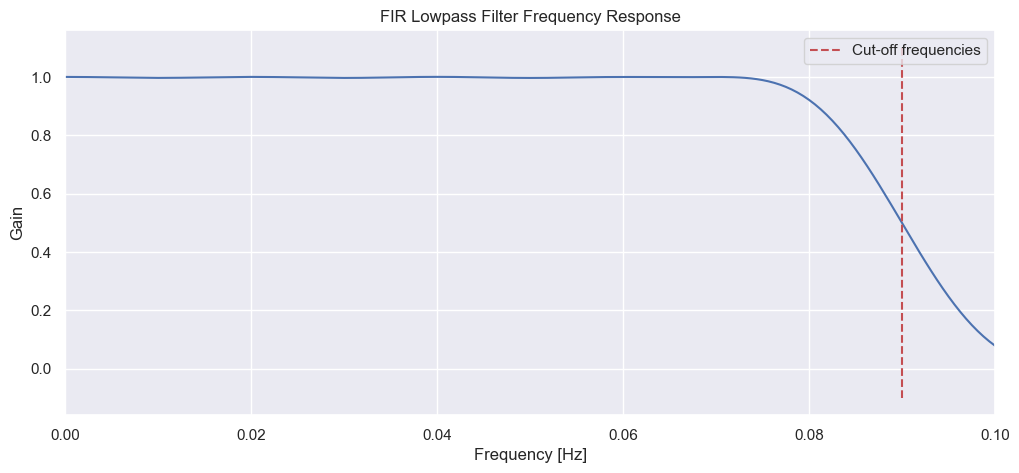

In [33]:
# Specifications
order = 1000
sample_rates = np.array(sfreqs)  # Example sample rate in Hz
nyquist_rates = sample_rates / 2.0
cutoff_freq = 0.09  # Cut-off frequencies in Hz

# Normalize the cut-off frequencies to Nyquist frequency
normalized_cutoffs = cutoff_freq  / nyquist_rates 

# Design the FIR bandpass filter using firwin
fir_coefficients = []
for sub in range(4):
    fir_coefficients.append(firwin(order + 1, normalized_cutoffs[sub], pass_zero='lowpass'))

# Plot the frequency response
w, h = freqz(fir_coefficients[0], worN=8000)
plt.figure(figsize=(12,5))
plt.plot(0.5 * sample_rates[0] * w / np.pi, np.abs(h), 'b')
plt.title('FIR Lowpass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
#plt.xscale('log')
plt.ylabel('Gain')
plt.xlim((0,0.1))
plt.vlines(cutoff_freq, -0.1, 1.1, linestyle = '--', color = 'r',  label = 'Cut-off frequencies')
plt.legend()
if export:
    plt.savefig('FIR_LPF_response_N_back_subject.png')
plt.show()

##### Define LPF

In [34]:
def BPF(raw_input, fir_coefficients, plot = False, export = False, filename = None):

    raw_ = raw_input.copy()
    data = raw_.get_data()
    picks = np.sort(_validate_nirs_info(raw_.info))

    for pick in picks:
        signal = data[pick]
        filtered_signal = filtfilt(fir_coefficients, 1.0, signal) # Zero phase filtering (Can only be done offline)
        
        raw_._data[pick] = filtered_signal
    
    if plot:
        compare_original_filtered(raw_, raw_input, export = export, filename = filename)
    
    return raw_

##### Perform LPF

In [35]:
raw_haemos_filtered = []
for sub in range(4):
    raw_haemos_filtered.append(BPF(raw_haemos[sub], fir_coefficients[sub], plot = plot, export = export, filename = 'BPF/N_back_LPF_subject_' + str(sub+1)))

##### Compare PSD before and after filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 204.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 204.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 231.424 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);


Effective window size : 231.424 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 229.376 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 229.376 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 251.904 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:2: FutureWarning: The value of `amplitude='auto'` wi

Effective window size : 251.904 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_23056\3708181797.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);


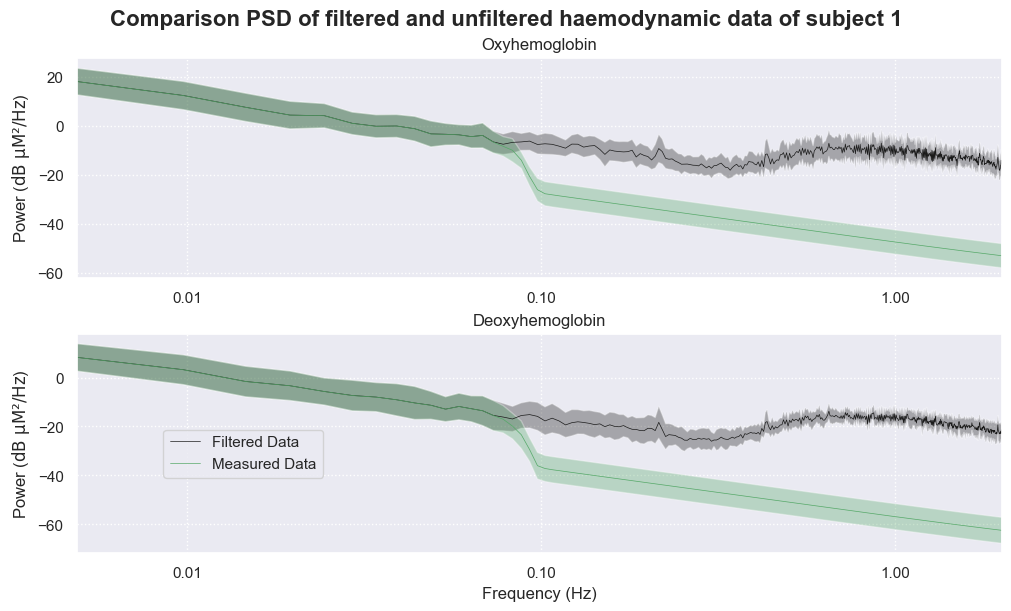

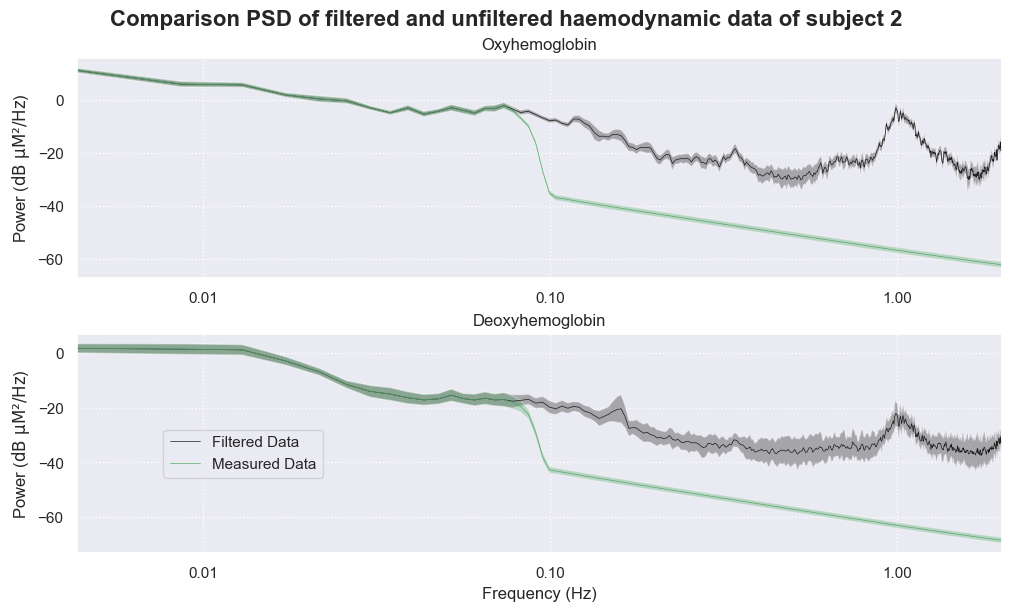

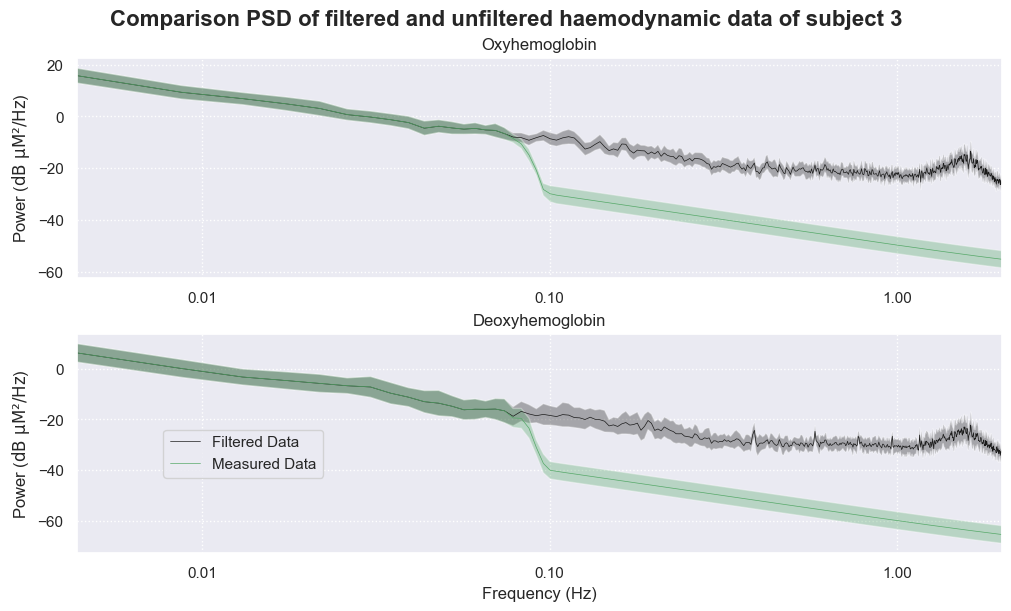

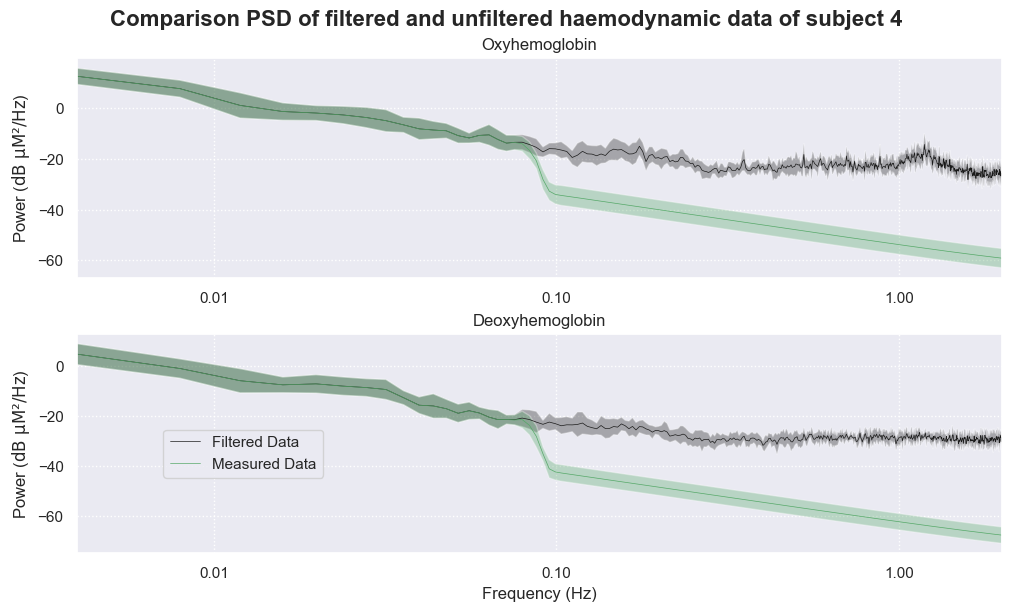

In [36]:
for sub in range(4):
    fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
    raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
    leg_lines = [line for line in fig.axes[0].lines if line.get_linestyle() == '-']
    fig.legend(leg_lines, ['Filtered Data', 'Measured Data'], loc="lower left", bbox_to_anchor=(0.15, 0.2))
    fig.suptitle('Comparison PSD of filtered and unfiltered haemodynamic data of subject ' + str(sub + 1), fontsize=16, fontweight='bold')
    if export:
        fig.savefig('PSD/N_back_PSD_comparison_after_LPF_subject_' + str(sub+1) + '.png')

## Post-processing <a class="anchor" id="chapter_2"></a>

### Data preparation <a class="anchor" id="section_2_1"></a>

Each participant performed three consecutive 20 minute during 2-back task blocks. Three pseudo-randomized 2-back task blocks were made (block a, block b and block c). The order of these blocks was once more randomized for each subject:

In [37]:
block_orders_dict = { 1 : ['a', 'c', 'b'], 2: ['c', 'b', 'a'], 3 : ['b', 'c', 'a'], 4: ['a', 'c', 'b']}
df = pd.DataFrame.from_dict(block_orders_dict, orient='index')

# Rename columns if necessary (optional)
df.columns = ['Block 1', 'Block 2', 'Block 3']
df

Block 1 Block 2 Block 3
1       a       c       b
2       c       b       a
3       b       c       a
4       a       c       b

Additionally all subjects performed a 0-back assignment of 2 minutes which will be used as baseline condition.

#### Selection channels used in analysis <a class="anchor" id="sub_section_2_1_1"></a>

In [38]:
MFG = [[1, 1], [2, 2], [3, 1], [3, 2], [10, 1], [11, 2], [12, 1], [12, 2]]
left_DLPFC = [[4, 3], [6, 3], [8, 3]]
right_DLPFC = [[5, 4], [7, 4], [9, 4]]

rois = dict(MFG_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy(), MFG, on_missing='warning'),
            left_DLPFC_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy(), left_DLPFC, on_missing='warning'),
            right_DLPFC_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy(), right_DLPFC, on_missing='warning')
           )

In [39]:
left = [[1, 1], [3, 1], [10, 1], [12, 1], [4, 3], [6, 3], [8, 3]]
right = [[2, 2], [3, 2], [11, 2], [12, 2], [5, 4], [7, 4], [9, 4]]

rois = dict(left_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy(), left, on_missing='warning'),
            right_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy(), right, on_missing='warning')
           )

In [40]:
# Select channels per subject and roi
dict_channels = []
for sub in range(1,5):
    d = dict()
    for roi in rois:
        l = np.array(raw_haemos_filtered[sub-1].ch_names)[rois[roi]]
        d[roi] = list(l[np.isin(list(np.array(raw_haemos_filtered[sub-1].ch_names)[rois[roi]]), raw_haemos_filtered[sub-1].info['bads'], invert = True)])
    dict_channels.append(d)

#### Crop and average fNIRS data according to task block <a class="anchor" id="sub_section_2_1_2"></a>

In [41]:
data_2_backs = []
start_stop_ids = []
blocks = ['0Back', '2Back_block1', '2Back_block2', '2Back_block3']
for sub in range(4):
    # Events in 2-back
    data_sub = []
    start_stop_ids_dict = dict()
    for block in blocks:
        id_start_block = events[sub][np.where(events[sub][:,2] == event_dicts[sub][block])[0][0]][0]
        id_end_block = events[sub][np.where(events[sub][:,2] == event_dicts[sub][block])[0][-1]][0] #index of last marker of this block
        id_end_block += int(np.round(np.mean(np.diff(events[sub][np.where(events[sub][:,2] == event_dicts[sub][block])[0]][:,0])))) # Add average distance between markers
        start_stop_ids_dict[block] = (id_start_block,id_end_block+1)
        data_sub.append(raw_haemos_filtered[sub].get_data()[:,id_start_block:id_end_block+1])
    data_2_backs.append(data_sub)
    start_stop_ids.append(start_stop_ids_dict)

##### Visualize result

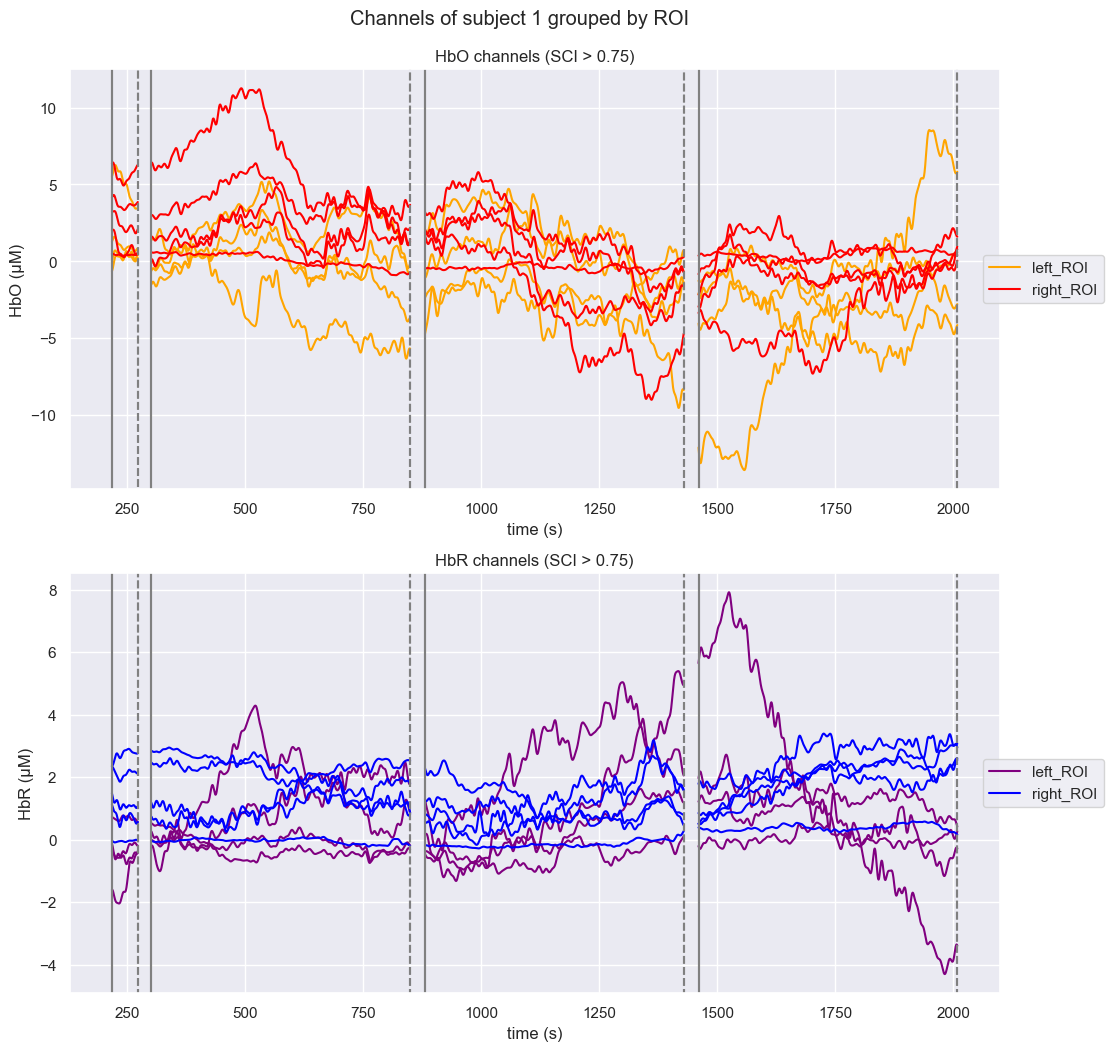

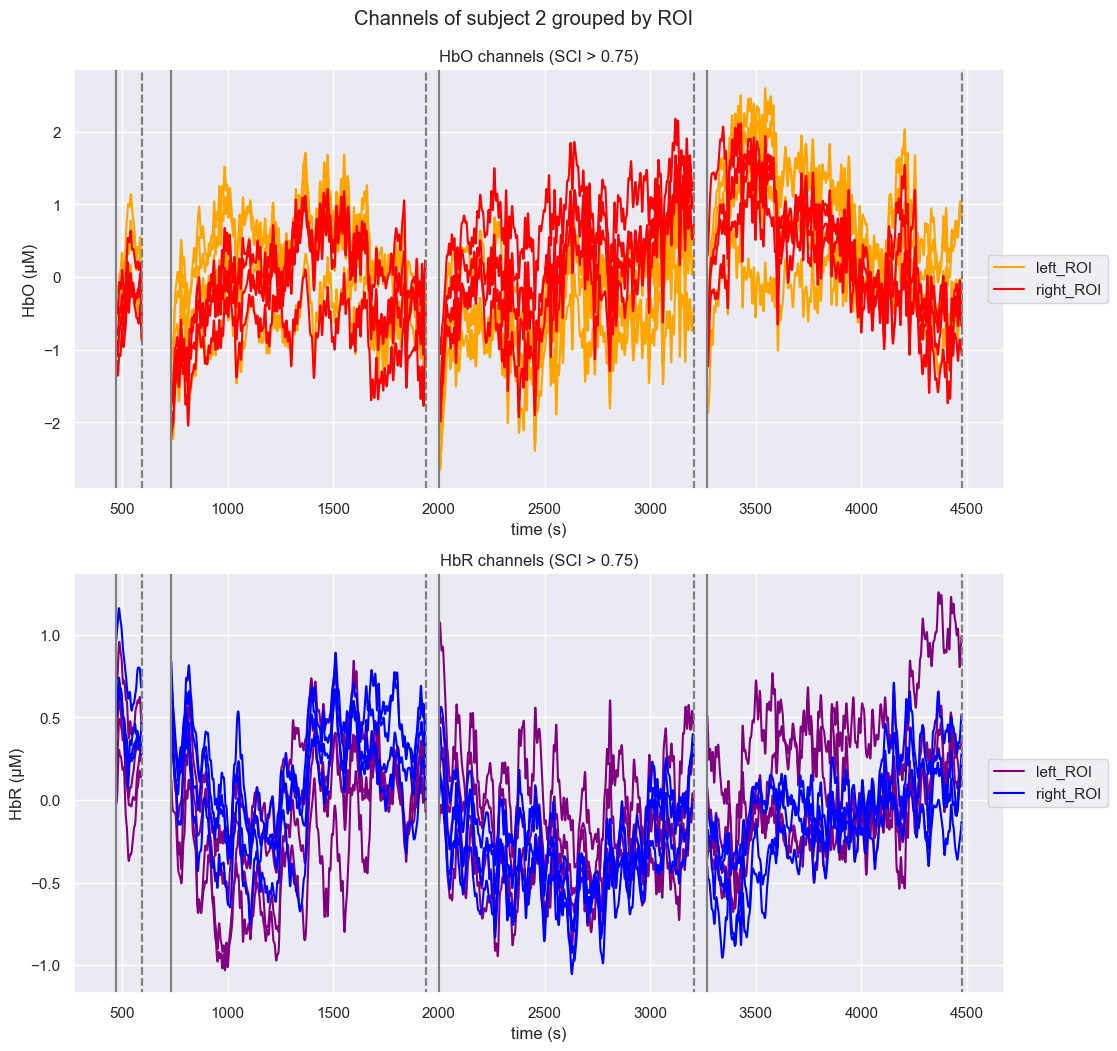

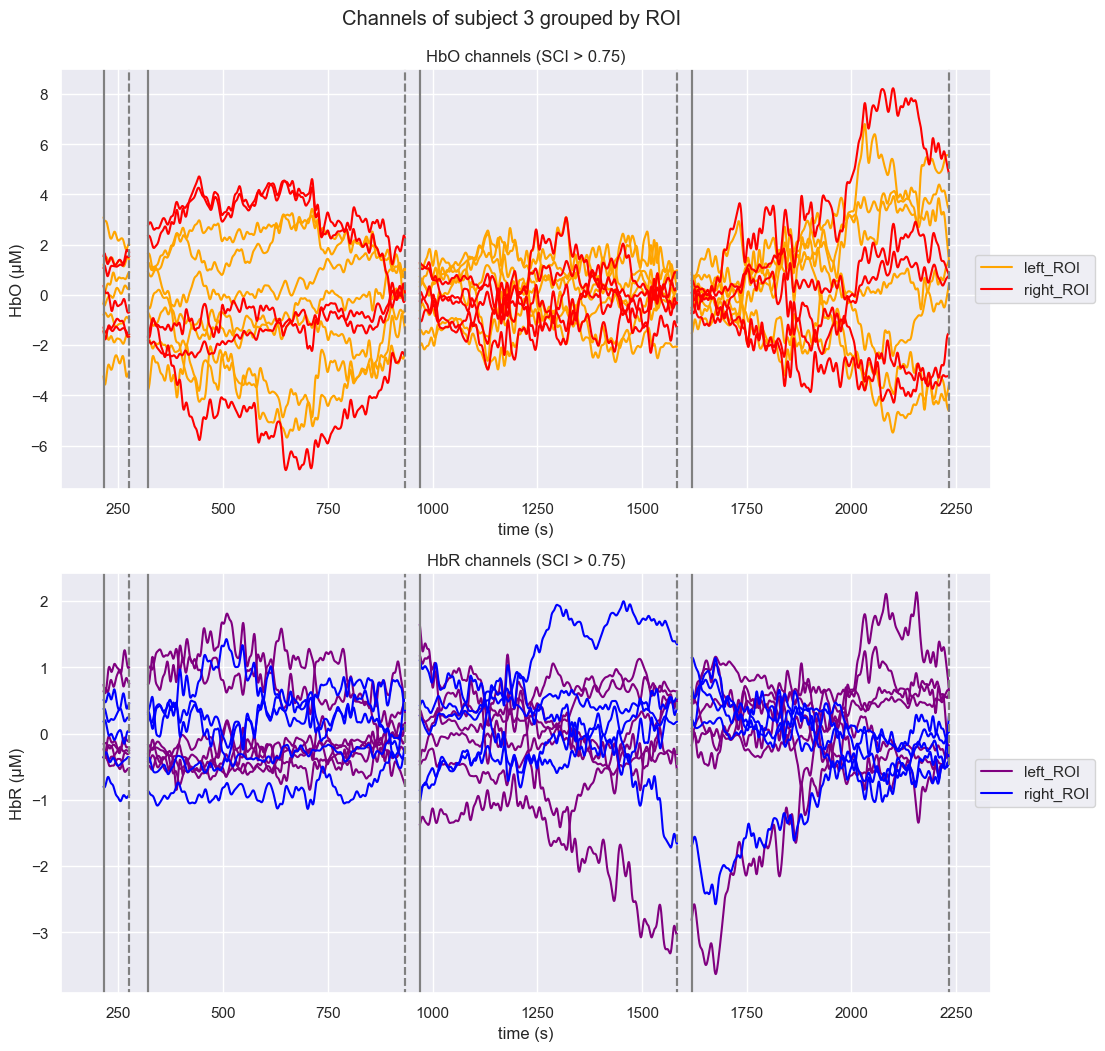

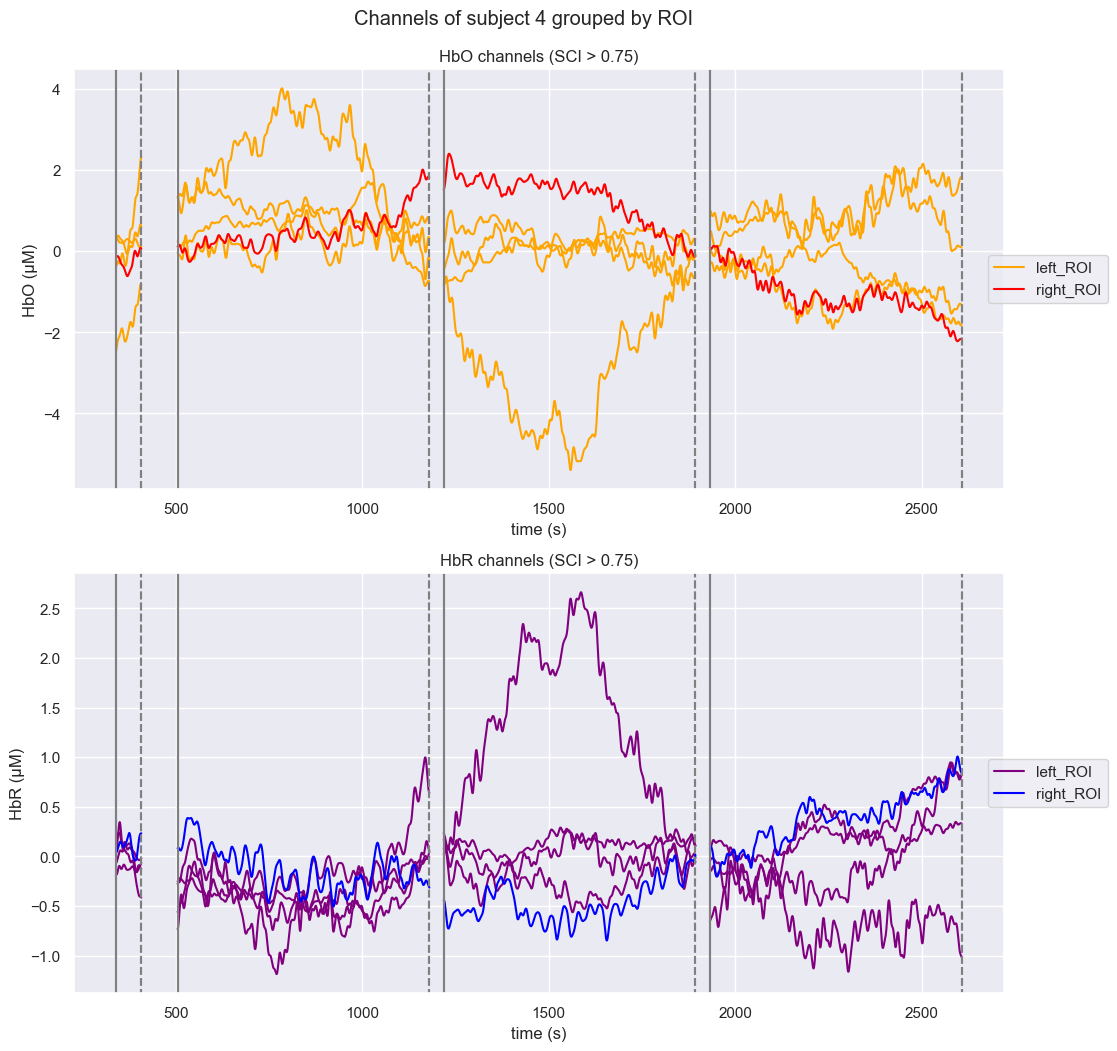

In [42]:
colors = ['orange', 'red', 'purple', 'blue']
for sub in range(4):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
    fig.suptitle('Channels of subject ' + str(sub+1) + ' grouped by ROI', y = 0.93)
    for i, roi in enumerate(rois):
        if len(dict_channels[sub][roi]) != 0:
            b = 0 
            for block in blocks:
                t = np.arange(start_stop_ids[sub][block][0], start_stop_ids[sub][block][1])/raw_haemos_filtered[sub].info['sfreq']
                if b == 0:
                    ax1.plot(t, 1e6*raw_haemos_filtered[sub].copy().pick(dict_channels[sub][roi]).get_data()[0, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]].T, label = roi, color = colors[i])
                    ax1.plot(t, 1e6*raw_haemos_filtered[sub].copy().pick(dict_channels[sub][roi]).get_data()[2::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]].T, color = colors[i])
                else:
                    ax1.plot(t, 1e6*raw_haemos_filtered[sub].copy().pick(dict_channels[sub][roi]).get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]].T, color = colors[i])
                ax1.axvline(start_stop_ids[sub][block][0]/raw_haemos_filtered[sub].info['sfreq'], ymin = np.min(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), ymax = np.max(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), color = '0.5')
                ax1.axvline(start_stop_ids[sub][block][1]/raw_haemos_filtered[sub].info['sfreq'], ymin = np.min(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), ymax = np.max(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), color = '0.5', linestyle = 'dashed')
                if b == 0:
                    ax2.plot(t, 1e6*raw_haemos_filtered[sub].copy().pick(dict_channels[sub][roi]).get_data()[1, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]].T, label = roi, color = colors[i+2])
                    ax2.plot(t, 1e6*raw_haemos_filtered[sub].copy().pick(dict_channels[sub][roi]).get_data()[3::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]].T, color = colors[i+2])
                else:
                    ax2.plot(t, 1e6*raw_haemos_filtered[sub].copy().pick(dict_channels[sub][roi]).get_data()[1::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]].T, color = colors[i+2])
                ax2.axvline(start_stop_ids[sub][block][0]/raw_haemos_filtered[sub].info['sfreq'], ymin = np.min(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), ymax = np.max(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), color = '0.5')
                ax2.axvline(start_stop_ids[sub][block][1]/raw_haemos_filtered[sub].info['sfreq'], ymin = np.min(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), ymax = np.max(1e6*raw_haemos_filtered[sub].get_data()[::2, start_stop_ids[sub][block][0]:start_stop_ids[sub][block][1]]), color = '0.5', linestyle = 'dashed')
                b = 1
    ax1.set_xlabel('time (s)')
    ax2.set_xlabel('time (s)')
    ax1.set_ylabel('HbO (µM)')
    ax2.set_ylabel('HbR (µM)')
    ax1.legend(loc='center right', bbox_to_anchor=(1.12, 0.5))
    ax2.legend(loc='center right', bbox_to_anchor=(1.12, 0.5))
    ax1.set_title('HbO channels (SCI > 0.75)')
    ax2.set_title('HbR channels (SCI > 0.75)')

    if export:
        fig.savefig('stat_analysis/channels_grouped_block_roi_subject_' + str(sub+1) + '.png')

##### Take mean value of each task block

In [43]:
mean_data = []
for sub in range(4):
    for b, block in enumerate(blocks):
        for roi in rois:
            for i in rois[roi]: #Keep only good channels
                chan = raw_haemos_filtered[sub].ch_names[i]
                if chan not in raw_haemos_filtered[sub].info['bads']:
                    mean = np.mean(1e6*data_2_backs[sub][b][i])
                    mean_data.append(['Subject ' + str(sub+1), b, chan[:-3], chan[-3:], roi[:-4], mean]) 
df = pd.DataFrame(mean_data, columns = ['Subject', 'Block', 'Channel', 'Chroma', 'ROI', 'Mean_value_block'])

In [44]:
df

Subject  Block  Channel Chroma    ROI  Mean_value_block
0    Subject 1      0   S1_D1     hbo   left          0.338202
1    Subject 1      0   S1_D1     hbr   left         -0.349780
2    Subject 1      0   S3_D1     hbo   left          0.995755
3    Subject 1      0   S3_D1     hbr   left          0.676134
4    Subject 1      0  S10_D1     hbo   left          0.257684
..         ...    ...      ...    ...    ...               ...
267  Subject 4      3  S10_D1     hbr   left         -0.354251
268  Subject 4      3   S4_D3     hbo   left          0.649543
269  Subject 4      3   S4_D3     hbr   left         -0.363223
270  Subject 4      3   S3_D2     hbo  right          0.505146
271  Subject 4      3   S3_D2     hbr  right         -0.125534

[272 rows x 6 columns]

##### Visualize result

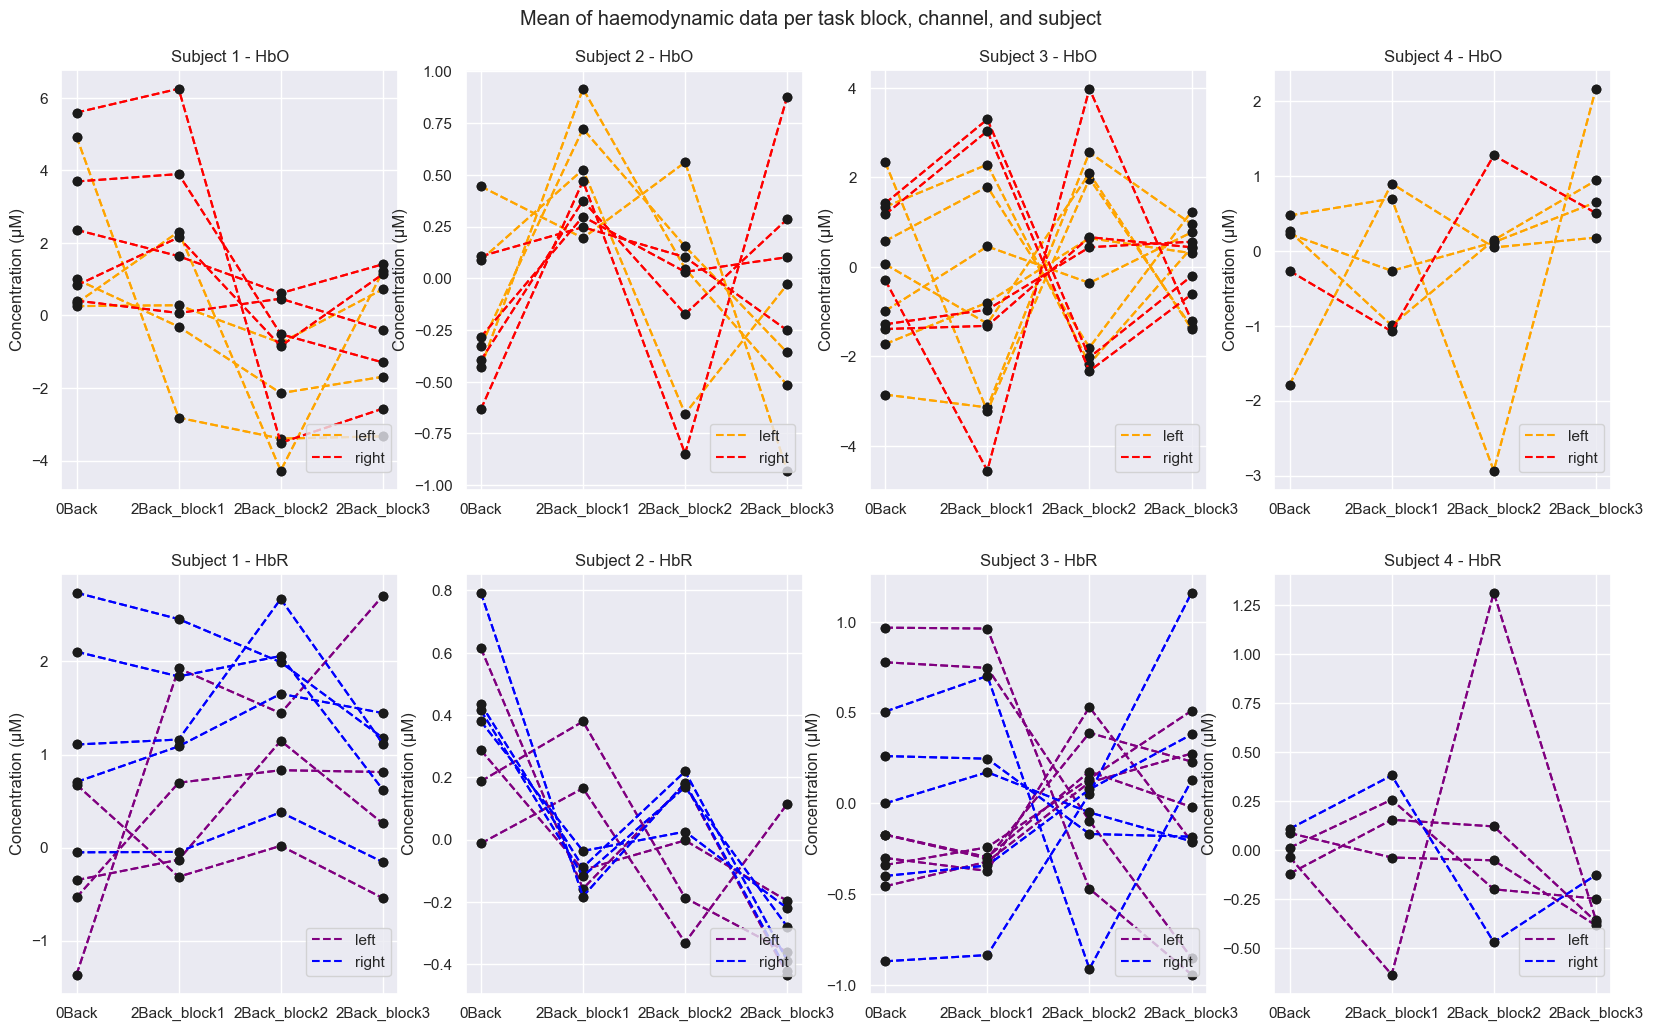

In [45]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Mean of haemodynamic data per task block, channel, and subject', y = 0.93)

for sub , tuple in enumerate([(ax1, ax5), (ax2, ax6), (ax3, ax7), (ax4, ax8)]):
    sub += 1
    data_subject = df[df['Subject'] == 'Subject ' + str(sub)]
    for i, roi in enumerate(rois):
        for j, chan in enumerate(dict_channels[sub-1][roi]):
            data_channel = data_subject[data_subject['Channel'] == chan[:-3]]
            
            data_channel_hbo = data_channel[data_channel['Chroma'] == 'hbo']
            data_channel_hbr = data_channel[data_channel['Chroma'] == 'hbr']

            if j == 0:
                tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], '--', color = colors[i], label = roi[:-4])
                tuple[0].legend(loc='center right', bbox_to_anchor=(1, 0.1))
            else:
                tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], '--', color = colors[i])
            tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], 'o', color='k')
             
            if j == 0:
                tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], '--', color = colors[i+2], label = roi[:-4])
                tuple[1].legend(loc='center right', bbox_to_anchor=(1, 0.1))
            else:
                tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], '--', color = colors[i+2])
            tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], 'o', color='k')
        
            tuple[0].set_title('Subject ' + str(sub) + ' - HbO')
            tuple[0].set_ylabel('Concentration (µM)')
            tuple[0].grid(visible=True)
        
            tuple[1].set_title('Subject ' + str(sub) + ' - HbR')
            tuple[1].set_ylabel('Concentration (µM)')
            tuple[1].grid(visible=True)

if export:
    fig.savefig('stat_analysis/mean_channels_grouped_block_roi.png')

### fNIRS data analysis <a class="anchor" id="section_2_2"></a>

#### Research question 1 <a class="anchor" id="sub_section_2_2_1"></a>

*Does brain activity in the prefrontal cortex show a significant increase with escalating levels of mental fatigue induced by three consecutive 20 minute 2-back tasks (decreasing HbR and increasing HbO)?*

**Hypothesis:** As mental fatigue levels increase during the 2-back task, there will be a significant rise in brain activity in the prefrontal cortex as measured by fNIRS.

In [124]:
model = smf.mixedlm("Mean_value_block ~ Chroma + Channel + Channel:Block:Chroma", df, groups=df["Subject"]).fit(method='nm')
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                 MixedLM      Dependent Variable:      Mean_value_block
No. Observations:      272          Method:                  REML            
No. Groups:            4            Scale:                   1.8281          
Min. group size:       40           Log-Likelihood:          -460.1818       
Max. group size:       96           Converged:               Yes             
Mean group size:       68.0                                                  
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.330    0.447  0.738 0.461 -0.547  1.207
Chroma[T.hbr]                      -0.143    0.274 -0.520 0.603 -0.680  0.395
Channel[T.S11_D2 ]                  0.030    0.613  0.050 0.960 -1.171  1.232
Channel[T.S12_D1 ]                  0.142    0.613  0.232 0.817 -1.060  1.344
Channel[T.S12_D2 ]                  0.378    0.698  0.542 0.588 -0.990  1.747
Channel[T.S1_D1 ]                  -0.700    0.566 -1.238 0.216 -1.809  0.409
Channel[T.S2_D2 ]                   0.875    0.613  1.428 0.153 -0.326  2.077
Channel[T.S3_D1 ]                  -0.294    0.566 -0.520 0.603 -1.403  0.814
Channel[T.S3_D2 ]                   0.353    0.566  0.624 0.532 -0.756  1.462
Channel[T.S4_D3 ]                  -0.443    0.698 -0.634 0.526 -1.811  0.926
Channel[T.S5_D4 ]                   0.335    0.698  0.481 0.631 -1.032  1.702
Channel[T.S6_D3 ]                   0.778    0.905  0.860 0.390 -0.995  2.551
Channel[T.S7_D4 ]                   1.043    0.905  1.153 0.249 -0.730  2.816
Channel[T.S8_D3 ]                   0.575    0.905  0.635 0.525 -1.198  2.348
Channel[S10_D1 ]:Block:Chroma[hbo] -0.161    0.256 -0.629 0.529 -0.662  0.341
Channel[S11_D2 ]:Block:Chroma[hbo] -0.057    0.294 -0.193 0.847 -0.632  0.519
Channel[S12_D1 ]:Block:Chroma[hbo] -0.717    0.294 -2.443 0.015 -1.292 -0.142
Channel[S12_D2 ]:Block:Chroma[hbo] -0.067    0.357 -0.188 0.851 -0.767  0.633
Channel[S1_D1 ]:Block:Chroma[hbo]   0.200    0.256  0.780 0.435 -0.302  0.701
Channel[S2_D2 ]:Block:Chroma[hbo]  -0.693    0.294 -2.361 0.018 -1.268 -0.118
Channel[S3_D1 ]:Block:Chroma[hbo]  -0.141    0.256 -0.550 0.582 -0.642  0.361
Channel[S3_D2 ]:Block:Chroma[hbo]  -0.209    0.256 -0.816 0.414 -0.710  0.293
Channel[S4_D3 ]:Block:Chroma[hbo]   0.238    0.357  0.667 0.505 -0.462  0.938
Channel[S5_D4 ]:Block:Chroma[hbo]  -0.377    0.357 -1.056 0.291 -1.077  0.323
Channel[S6_D3 ]:Block:Chroma[hbo]  -0.259    0.502 -0.516 0.606 -1.242  0.724
Channel[S7_D4 ]:Block:Chroma[hbo]  -0.755    0.502 -1.505 0.132 -1.738  0.228
Channel[S8_D3 ]:Block:Chroma[hbo]  -0.363    0.502 -0.723 0.470 -1.346  0.620
Channel[S10_D1 ]:Block:Chroma[hbr] -0.040    0.256 -0.158 0.875 -0.542  0.461
Channel[S11_D2 ]:Block:Chroma[hbr]  0.099    0.294  0.337 0.736 -0.476  0.674
Channel[S12_D1 ]:Block:Chroma[hbr]  0.163    0.294  0.555 0.579 -0.412  0.738
Channel[S12_D2 ]:Block:Chroma[hbr] -0.001    0.357 -0.004 0.997 -0.701  0.698
Channel[S1_D1 ]:Block:Chroma[hbr]   0.274    0.256  1.073 0.283 -0.227  0.776
Channel[S2_D2 ]:Block:Chroma[hbr]  -0.224    0.294 -0.765 0.444 -0.800  0.351
Channel[S3_D1 ]:Block:Chroma[hbr]  -0.023    0.256 -0.090 0.928 -0.525  0.479
Channel[S3_D2 ]:Block:Chroma[hbr]  -0.072    0.256 -0.283 0.777 -0.574  0.429
Channel[S4_D3 ]:Block:Chroma[hbr]   0.160    0.357  0.448 0.654 -0.540  0.860
Channel[S5_D4 ]:Block:Chroma[hbr]  -0.271    0.357 -0.758 0.448 -0.971  0.429
Channel[S6_D3 ]:Block:Chroma[hbr]  -0.475    0.502 -0.947 0.344 -1.458  0.508
Channel[S7_D4 ]:Block:Chroma[hbr]  -0.491    0.502 -0.980 0.327 -1.474  0.492
Channel[S8_D3 ]:Block:Chroma[hbr]  -0.241    0.502 -0.480 0.631 -1.224 

In [118]:
if export:
    table1, table2 = model.summary().tables
    table1.columns = table1.iloc[0]
    table1 = table1.drop([0])
    dfi.export(table1,"stat_analysis/N_back_RQ1_table1.png")
    dfi.export(table2,"stat_analysis/N_back_RQ1_table2.png")

In [125]:
df['Fitted_mean_value'] = model.fittedvalues

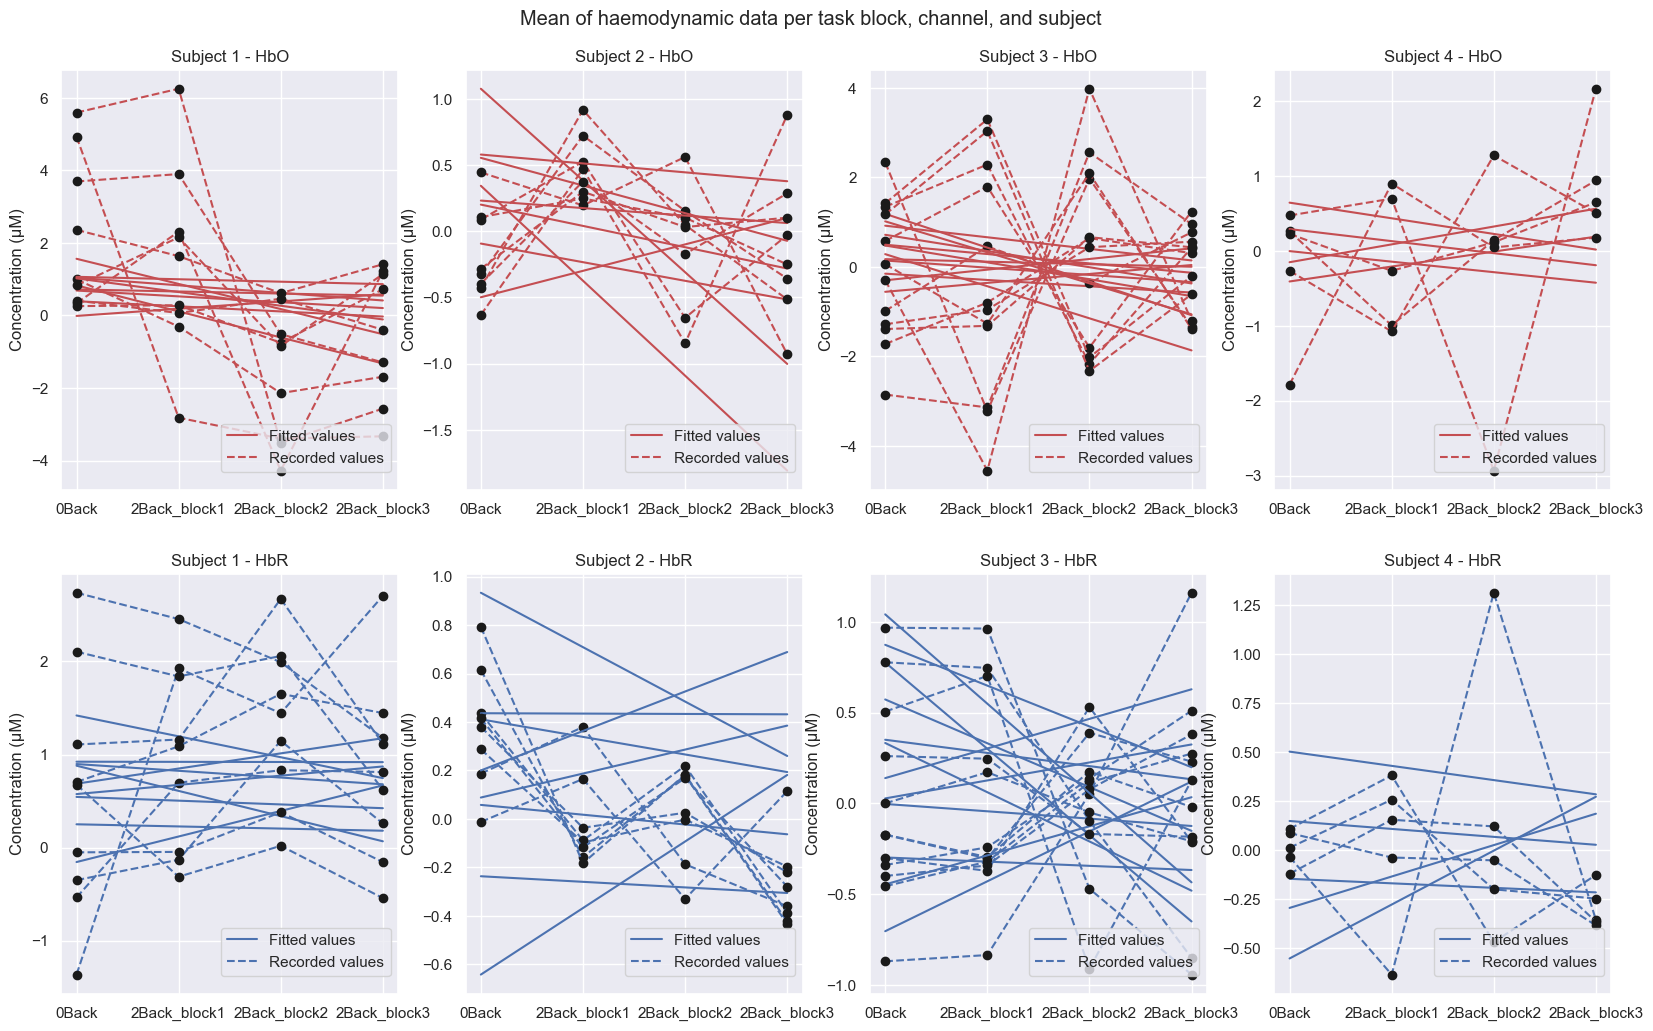

In [126]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Mean of haemodynamic data per task block, channel, and subject', y = 0.93)

for sub , tuple in enumerate([(ax1, ax5), (ax2, ax6), (ax3, ax7), (ax4, ax8)]):
    sub += 1
    data_subject = df[df['Subject'] == 'Subject ' + str(sub)]
    for i, roi in enumerate(rois):
        for j, chan in enumerate(dict_channels[sub-1][roi][::2]):
            data_channel = data_subject[data_subject['Channel'] == chan[:-3]]
            
            data_channel_hbo = data_channel[data_channel['Chroma'] == 'hbo']
            data_channel_hbr = data_channel[data_channel['Chroma'] == 'hbr']

            if j == 0 and i == 0:
                tuple[0].plot(blocks, data_channel_hbo['Fitted_mean_value'], '-', color= 'r', label = 'Fitted values')
                tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], '--', color = 'r', label = 'Recorded values')
                tuple[0].legend(loc='center right', bbox_to_anchor=(1, 0.1))
            else:
                tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], '--', color = 'r')
                tuple[0].plot(blocks, data_channel_hbo['Fitted_mean_value'], '-', color= 'r')
            tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], 'o', color='k')
            
            
            if j == 0 and i == 0:
                tuple[1].plot(blocks, data_channel_hbr['Fitted_mean_value'], '-', color= 'b', label ='Fitted values')
                tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], '--', color = 'b', label = 'Recorded values')
                tuple[1].legend(loc='center right', bbox_to_anchor=(1, 0.1))
            else:
                tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], '--', color = 'b')
                tuple[1].plot(blocks, data_channel_hbr['Fitted_mean_value'], '-', color= 'b')
            tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], 'o', color='k')
            
            
            tuple[0].set_title('Subject ' + str(sub) + ' - HbO')
            tuple[0].set_ylabel('Concentration (µM)')
            tuple[0].grid(visible=True)
        
            tuple[1].set_title('Subject ' + str(sub) + ' - HbR')
            tuple[1].set_ylabel('Concentration (µM)')
            tuple[1].grid(visible=True)

if export:
    fig.savefig('stat_analysis/fitted_mean_channels_grouped_block.png')

##### Check assumptions of LMM

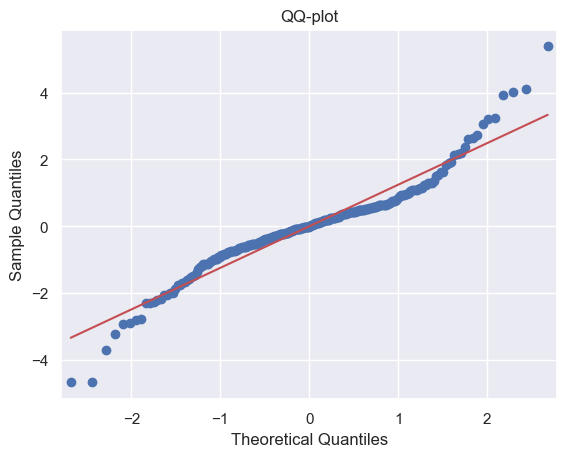

In [127]:
sm.qqplot(model.resid, dist = norm, line = 's')
plt.title('QQ-plot')

plt.show()

In [128]:
# Shapiro-wilk test for normality
resid = model.resid
alpha = 0.05

SH = dict()
SH['statistic'] = shapiro(resid)[0]
SH['pvalue'] = shapiro(resid)[1]
SH['Significance'] = 'Not normally distributed' if SH['pvalue'] < alpha else 'Normally distributed'
SH

{'statistic': 0.936618447303772,
 'pvalue': 2.0692234592445402e-09,
 'Significance': 'Not normally distributed'}

In [129]:
# White’s Lagrange Multiplier Test for Heteroscedasticity
WLM = dict()
exog = model.model.exog
WLM["LM Statistic"] = het_white(resid, exog)[0]
WLM["LM-Test p-value"] = het_white(resid, exog)[1]
WLM["F-Statistic"] = het_white(resid, exog)[2]
WLM["F-Test p-value"] = het_white(resid, exog)[3]
WLM['Significance LM-test'] = 'Heteroscedastic' if WLM['LM-Test p-value'] < alpha else 'Homoscedastic'
WLM['Significance F-test'] = 'Heteroscedastisticity in the residual errors' if WLM['F-Test p-value'] < alpha else 'No heteroscedastisticity in the residual errors'
WLM

{'LM Statistic': 88.90395063035011,
 'LM-Test p-value': 0.16678705723435355,
 'F-Statistic': 1.223356661649271,
 'F-Test p-value': 0.13600881342808363,
 'Significance LM-test': 'Homoscedastic',
 'Significance F-test': 'No heteroscedastisticity in the residual errors'}

---
> *Remark:*
- Residuals are not normally distibuted violating the assumptions of the LMM
- The model may not adequately capture the true relationship between the dependent variable and the predictors
- The small sample sizes can lead to non-normal residuals due to increased variability and less ability to approximate the normal distribution
---

#### Research question 2 <a class="anchor" id="sub_section_2_2_2"></a>

*Is there a distinct difference in brain activity between the left and right prefrontal cortex as mental fatigue levels increase during N-back tasks?*

**Hypothesis:** Increasing levels of mental fatigue induced by N-back tasks will lead to a noticeable difference in brain activity between the left and right prefrontal cortex, as measured by fNIRS.

In [130]:
# Fit model
model2 = smf.mixedlm("Mean_value_block ~ Chroma + ROI + ROI:Block:Chroma", df, groups=df["Subject"]).fit(method='nm')
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:               MixedLM    Dependent Variable:    Mean_value_block
No. Observations:    272        Method:                REML            
No. Groups:          4          Scale:                 1.7367          
Min. group size:     40         Log-Likelihood:        -467.4322       
Max. group size:     96         Converged:             Yes             
Mean group size:     68.0                                              
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.162    0.259  0.625 0.532 -0.346  0.670
Chroma[T.hbr]                -0.143    0.267 -0.533 0.594 -0.667  0.381
ROI[T.right]                  0.606    0.271  2.234 0.025  0.074  1.138
ROI[left]:Block:Chroma[hbo]  -0.142    0.125 -1.136 0.256 -0.388  0.103
ROI[right]:Block:Chroma[hbo] -0.315    0.138 -2.287 0.022 -0.585 -0.045
ROI[left]:Block:Chroma[hbr]   0.049    0.125  0.394 0.694 -0.196  0.295
ROI[right]:Block:Chroma[hbr] -0.113    0.138 -0.823 0.410 -0.384  0.157
Group Var                     0.068    0.057                           
=======================================================================

"""

In [131]:
df['Fitted_mean_value_roi'] = model2.fittedvalues

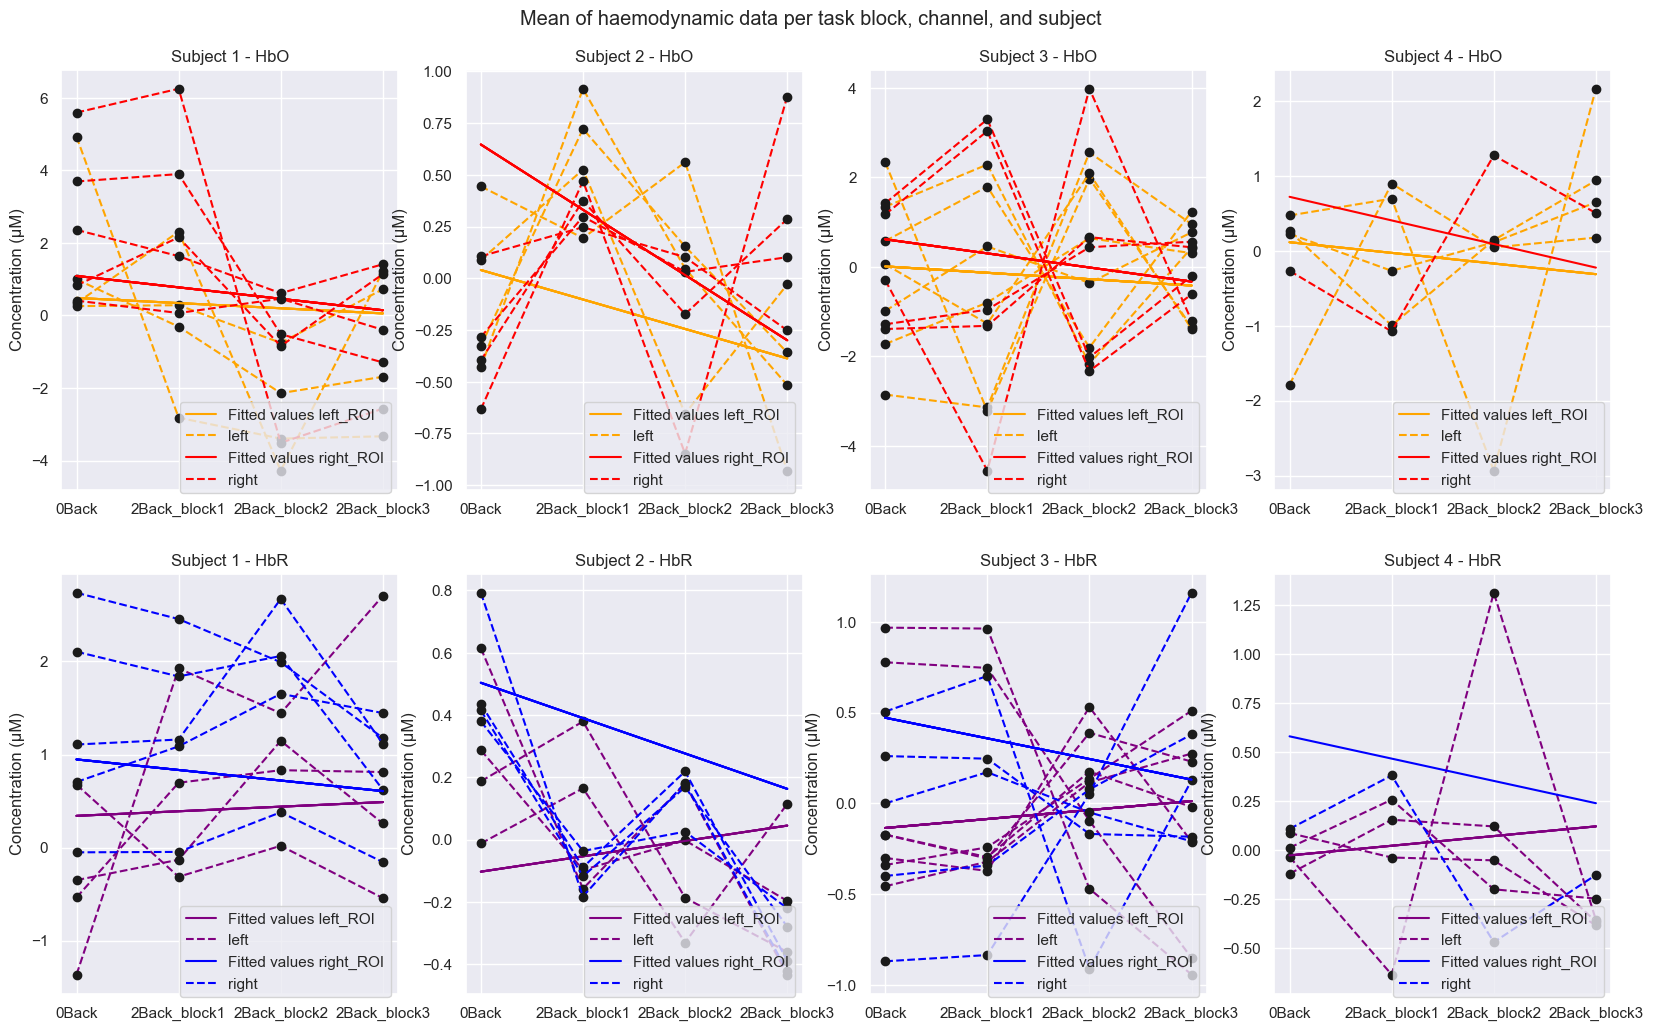

In [132]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Mean of haemodynamic data per task block, channel, and subject', y = 0.93)

for sub , tuple in enumerate([(ax1, ax5), (ax2, ax6), (ax3, ax7), (ax4, ax8)]):
    sub += 1
    data_subject = df[df['Subject'] == 'Subject ' + str(sub)]
    for i, roi in enumerate(rois):
        for j, chan in enumerate(dict_channels[sub-1][roi][::2]):
            data_channel = data_subject[data_subject['Channel'] == chan[:-3]]
            
            data_channel_hbo = data_channel[data_channel['Chroma'] == 'hbo']
            data_channel_hbr = data_channel[data_channel['Chroma'] == 'hbr']

            if j == 0:
                tuple[0].plot(blocks, data_channel_hbo['Fitted_mean_value_roi'], '-', color= colors[i], label = 'Fitted values ' + roi)
                tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], '--', color = colors[i], label = roi[:-4])
                tuple[0].legend(loc='center right', bbox_to_anchor=(1, 0.1))
            else:
                tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], '--', color = colors[i])
                tuple[0].plot(blocks, data_channel_hbo['Fitted_mean_value_roi'], '-', color= colors[i])
            tuple[0].plot(blocks, data_channel_hbo['Mean_value_block'], 'o', color='k')
            
            
            if j == 0:
                tuple[1].plot(blocks, data_channel_hbr['Fitted_mean_value_roi'], '-', color= colors[i+2], label = 'Fitted values ' + roi)
                tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], '--', color = colors[i+2], label = roi[:-4])
                tuple[1].legend(loc='center right', bbox_to_anchor=(1, 0.1))
            else:
                tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], '--', color = colors[i+2])
                tuple[1].plot(blocks, data_channel_hbr['Fitted_mean_value_roi'], '-', color= colors[i+2])
            tuple[1].plot(blocks, data_channel_hbr['Mean_value_block'], 'o', color='k')
            
            
            tuple[0].set_title('Subject ' + str(sub) + ' - HbO')
            tuple[0].set_ylabel('Concentration (µM)')
            tuple[0].grid(visible=True)
        
            tuple[1].set_title('Subject ' + str(sub) + ' - HbR')
            tuple[1].set_ylabel('Concentration (µM)')
            tuple[1].grid(visible=True)

if export:
    fig.savefig('stat_analysis/fitted_mean_channels_grouped_block_roi.png')

##### Check assumptions of LMM

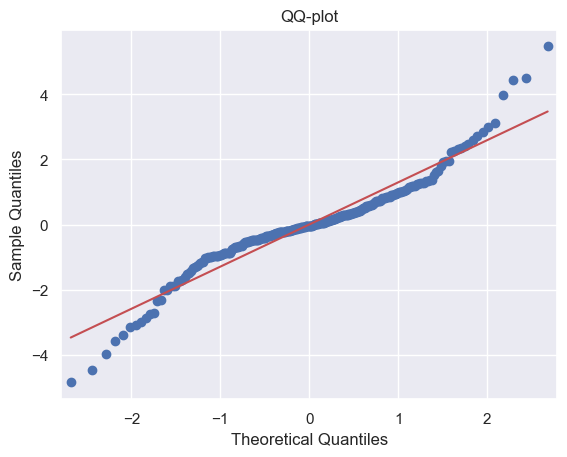

In [133]:
sm.qqplot(model2.resid, dist = norm, line = 's')
plt.title('QQ-plot')

plt.show()

In [134]:
# Shapiro-wilk test for normality
resid = model2.resid
alpha = 0.05

SH = dict()
SH['statistic'] = shapiro(resid)[0]
SH['pvalue'] = shapiro(resid)[1]
SH['Significance'] = 'Not normally distributed' if SH['pvalue'] < alpha else 'Normally distributed'
SH

{'statistic': 0.9340997338294983,
 'pvalue': 1.1891401197061668e-09,
 'Significance': 'Not normally distributed'}

---
> *Remark:*
- Residuals are not normally distibuted violating the assumptions of the LMM
- The model may not adequately capture the true relationship between the dependent variable and the predictors
- The small sample sizes can lead to non-normal residuals due to increased variability and less ability to approximate the normal distribution
---

In [135]:
# White’s Lagrange Multiplier Test for Heteroscedasticity
WLM = dict()
exog = model2.model.exog
WLM["LM Statistic"] = het_white(resid, exog)[0]
WLM["LM-Test p-value"] = het_white(resid, exog)[1]
WLM["F-Statistic"] = het_white(resid, exog)[2]
WLM["F-Test p-value"] = het_white(resid, exog)[3]
WLM['Significance LM-test'] = 'Heteroscedastic' if WLM['LM-Test p-value'] < alpha else 'Homoscedastic'
WLM['Significance F-test'] = 'Heteroscedastisticity in the residual errors' if WLM['F-Test p-value'] < alpha else 'No heteroscedastisticity in the residual errors'
WLM

{'LM Statistic': 41.314307307235744,
 'LM-Test p-value': 2.1275914510761185e-05,
 'F-Statistic': 4.2331190092437385,
 'F-Test p-value': 8.667404207787347e-06,
 'Significance LM-test': 'Heteroscedastic',
 'Significance F-test': 'Heteroscedastisticity in the residual errors'}

---
> *Remark:*
- Assumption of homoscedasticity (constant variance of residuals) is violated
- Presence of outliers or extreme values in the data can cause heteroscedasticity
- The relationship between predictors and the response variable is non-linear and this non-linearity varies across levels of other predictors, it can lead to varying residuals' variance
---